In [1]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro, kstest
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

# Загрузка данных

In [2]:
df = pd.read_csv("../Data/American Companies/FORD 1994 2022.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,02.06.1972,2.153220,2.173495,2.141055,2.149165,0.266799,1174468
1,05.06.1972,2.149165,2.169440,2.141055,2.149165,0.266799,5209582
2,06.06.1972,2.149165,2.157275,2.116725,2.124835,0.263778,1424158
3,07.06.1972,2.124835,2.137000,2.112670,2.112670,0.262268,675088
4,08.06.1972,2.112670,2.128890,2.096449,2.096449,0.260255,1038834
...,...,...,...,...,...,...,...
12740,08.12.2022,13.200000,13.260000,13.070000,13.120000,13.120000,32376300
12741,09.12.2022,13.040000,13.360000,13.040000,13.180000,13.180000,41531600
12742,12.12.2022,13.200000,13.470000,13.100000,13.460000,13.460000,35473800
12743,13.12.2022,13.780000,13.920000,13.370000,13.570000,13.570000,57872100


In [3]:
open_price = df.Open
date = df.Date.apply(lambda x: pd.to_datetime(x, dayfirst= True))

In [4]:
bad_data = []
for ind, el in enumerate(open_price):
    try:
        float(el)
        assert(el != "0")
    except:
        print(el)
        bad_data.append(ind)

In [5]:
bad_data = np.array(bad_data)

In [6]:
open_price = open_price.drop(bad_data)
dates = date.drop(bad_data)

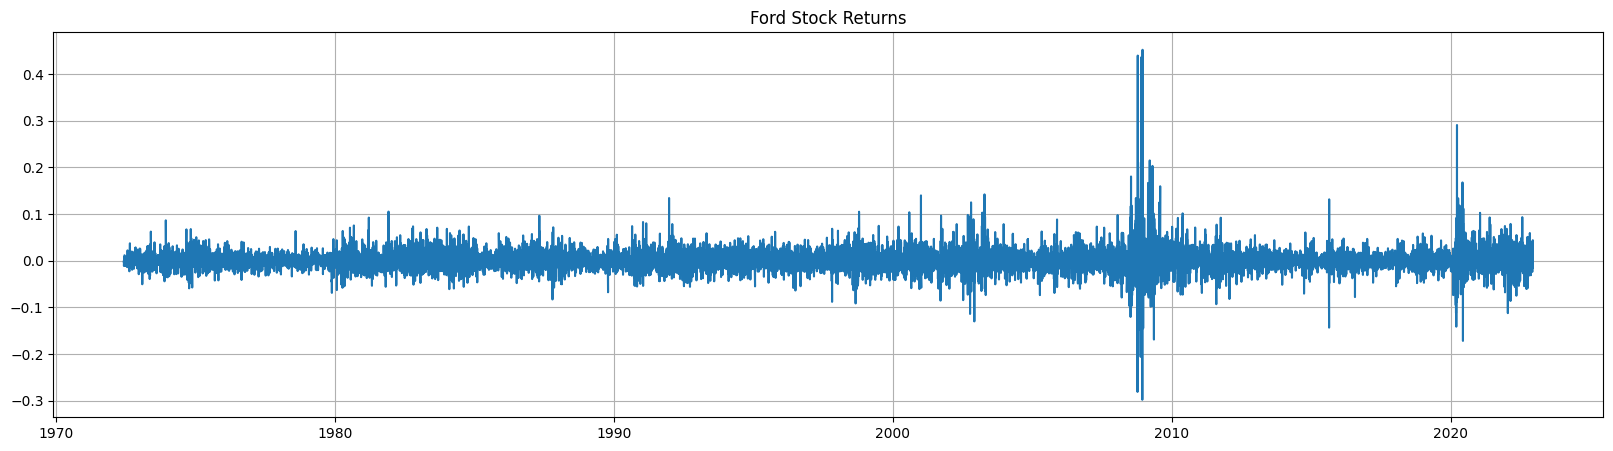

In [7]:
plt.figure(figsize= (20 , 5))
plt.title("Ford Stock Returns")
plt.plot(dates[1:], open_price.pct_change()[1:])
plt.grid(True)
plt.show()

In [8]:
prc_change_open_prices = open_price.pct_change()[1:]
dates = dates[1:]

In [9]:
prc_change_open_prices = prc_change_open_prices.astype(np.float32).to_numpy()
dates = dates.to_numpy()

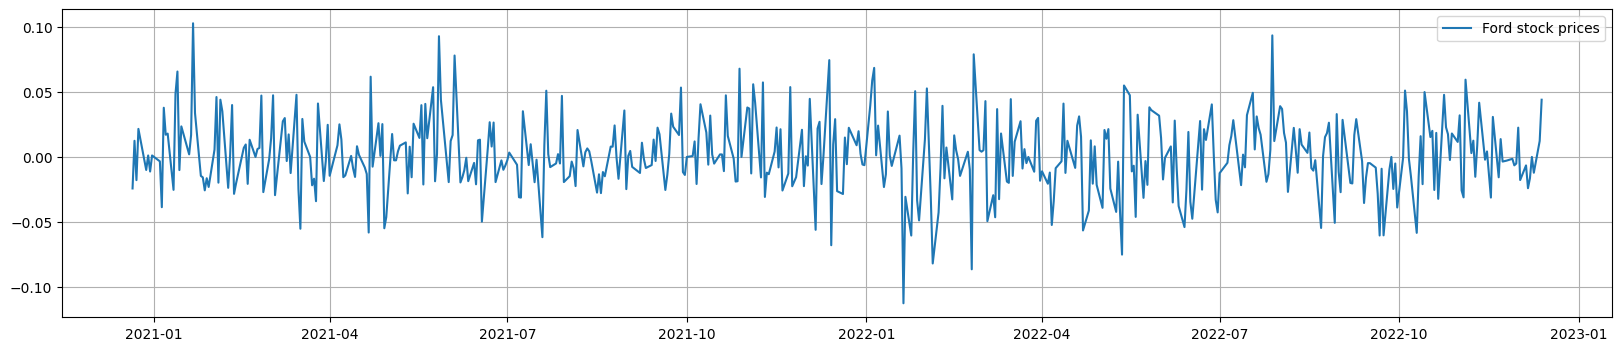

In [10]:
plt.figure(figsize= (20, 4))
plt.plot(dates[-500:-1], prc_change_open_prices[-500:-1], label= "Ford stock prices")
# plt.scatter(dates[-500:-1], prc_change_open_prices[-500:-1], c="orange")
plt.grid(True)
plt.legend(loc= "best")
plt.show()

# Преобразование данных во входные данные

In [11]:
def data_to_X_y(x, window_size= 40):
    X = []
    y = []
    for i in range(len(x) - window_size):
        row = list(map(lambda a: [a], x[i:i + window_size]))
        X.append(np.array(row))
        col = [x[i + window_size]]
        y.append(np.array(col))

    return np.array(X), np.array(y)

### Удаление аномалий

In [12]:
detector = IsolationForest(bootstrap= True, contamination= 0.025, random_state= 42, n_jobs= -1)
detector.fit(prc_change_open_prices.reshape(-1, 1))

IsolationForest(bootstrap=True, contamination=0.025, n_jobs=-1, random_state=42)

In [13]:
# доля выбросов составляет 0.025 от общего числа.
decisions = detector.predict(prc_change_open_prices.reshape(-1, 1))

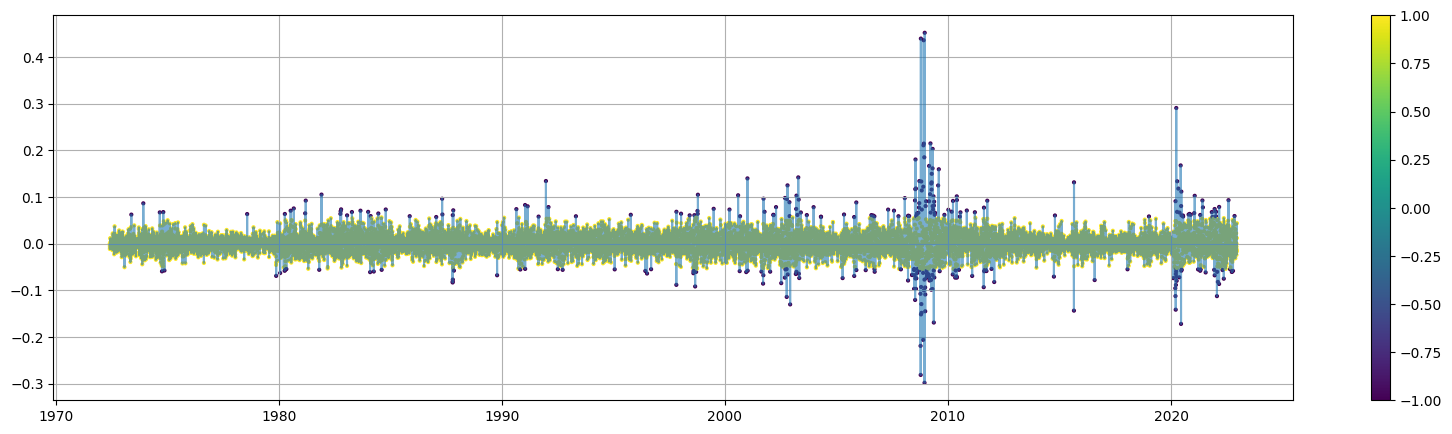

In [14]:
# Визуализация исходных доходностей (с раскраской выбросов)
plt.figure(figsize= (20, 5))
plt.grid(True)
plt.plot(dates, prc_change_open_prices, alpha= 0.6)
plt.scatter(dates, prc_change_open_prices, c= decisions, s= 4)
plt.colorbar()
plt.show()

In [15]:
# Отчистка от выбросов
no_anomalies = np.array(list(map(lambda x: x == 1, decisions)))
new_prc_change_open_prices = prc_change_open_prices[no_anomalies]
new_dates = dates[no_anomalies]

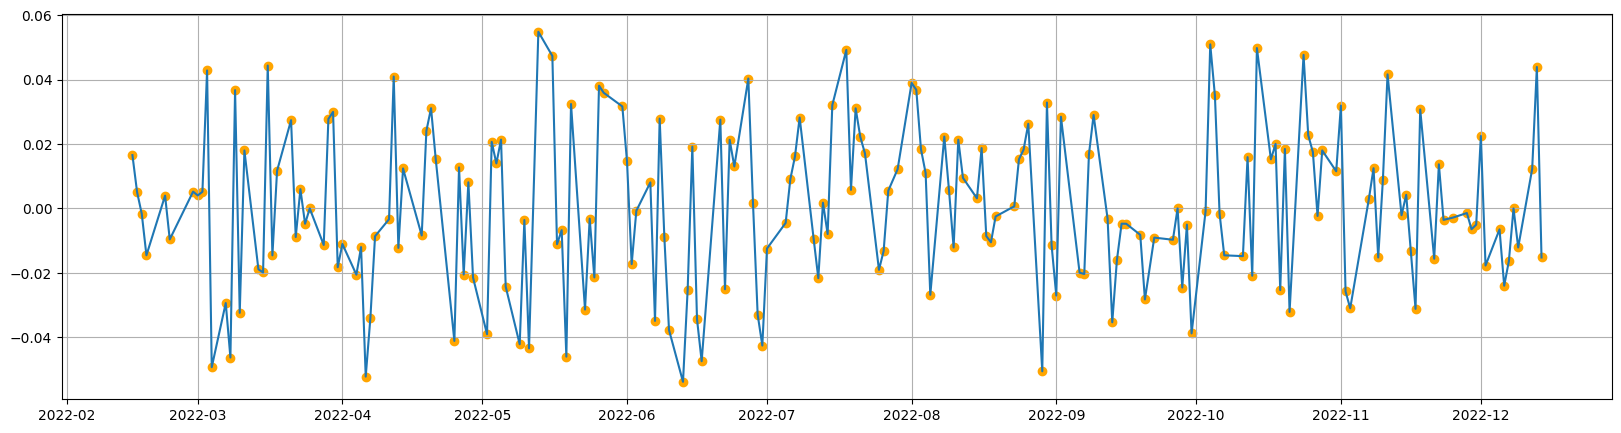

In [16]:
plt.figure(figsize= (20, 5))
plt.grid(True)
plt.plot(new_dates[-200:None], new_prc_change_open_prices[-200:None])
plt.scatter(new_dates[-200:None], new_prc_change_open_prices[-200:None], c= "orange")
plt.show()

### Разложение ряда на шум и тренд (сезонности нет)

In [17]:
from SSA.SSA import SSA

In [18]:
N = len(new_prc_change_open_prices)
L = 50
K = N - L + 1

open_price_matrix = SSA.x_to_Hankelian(new_prc_change_open_prices, L, K)
U, S, Vt = np.linalg.svd(open_price_matrix)
V = Vt.T

x_hat = np.array([SSA.Hankelian_to_TS(SSA.get_elementry_matrix(U[:, i].reshape(-1, 1), S[i], V[:, i])) for i in range(len(S))])

U.shape, V.shape, x_hat.shape

((50, 50), (12378, 12378), (50, 12427))

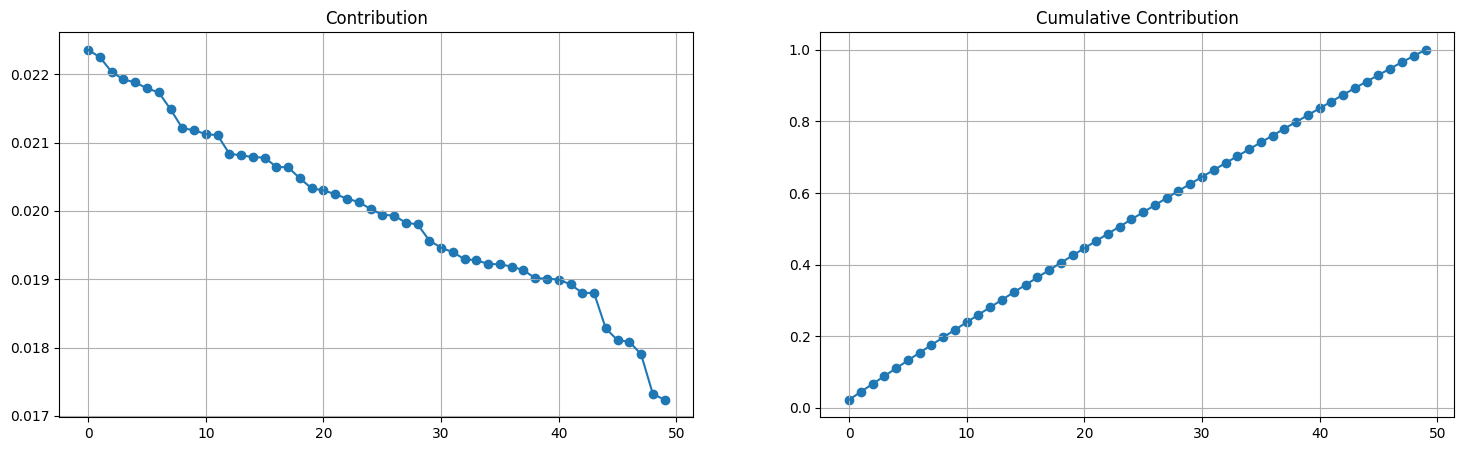

In [19]:
res = SSA.get_contribution(S)
SSA.plot_contribution(res);

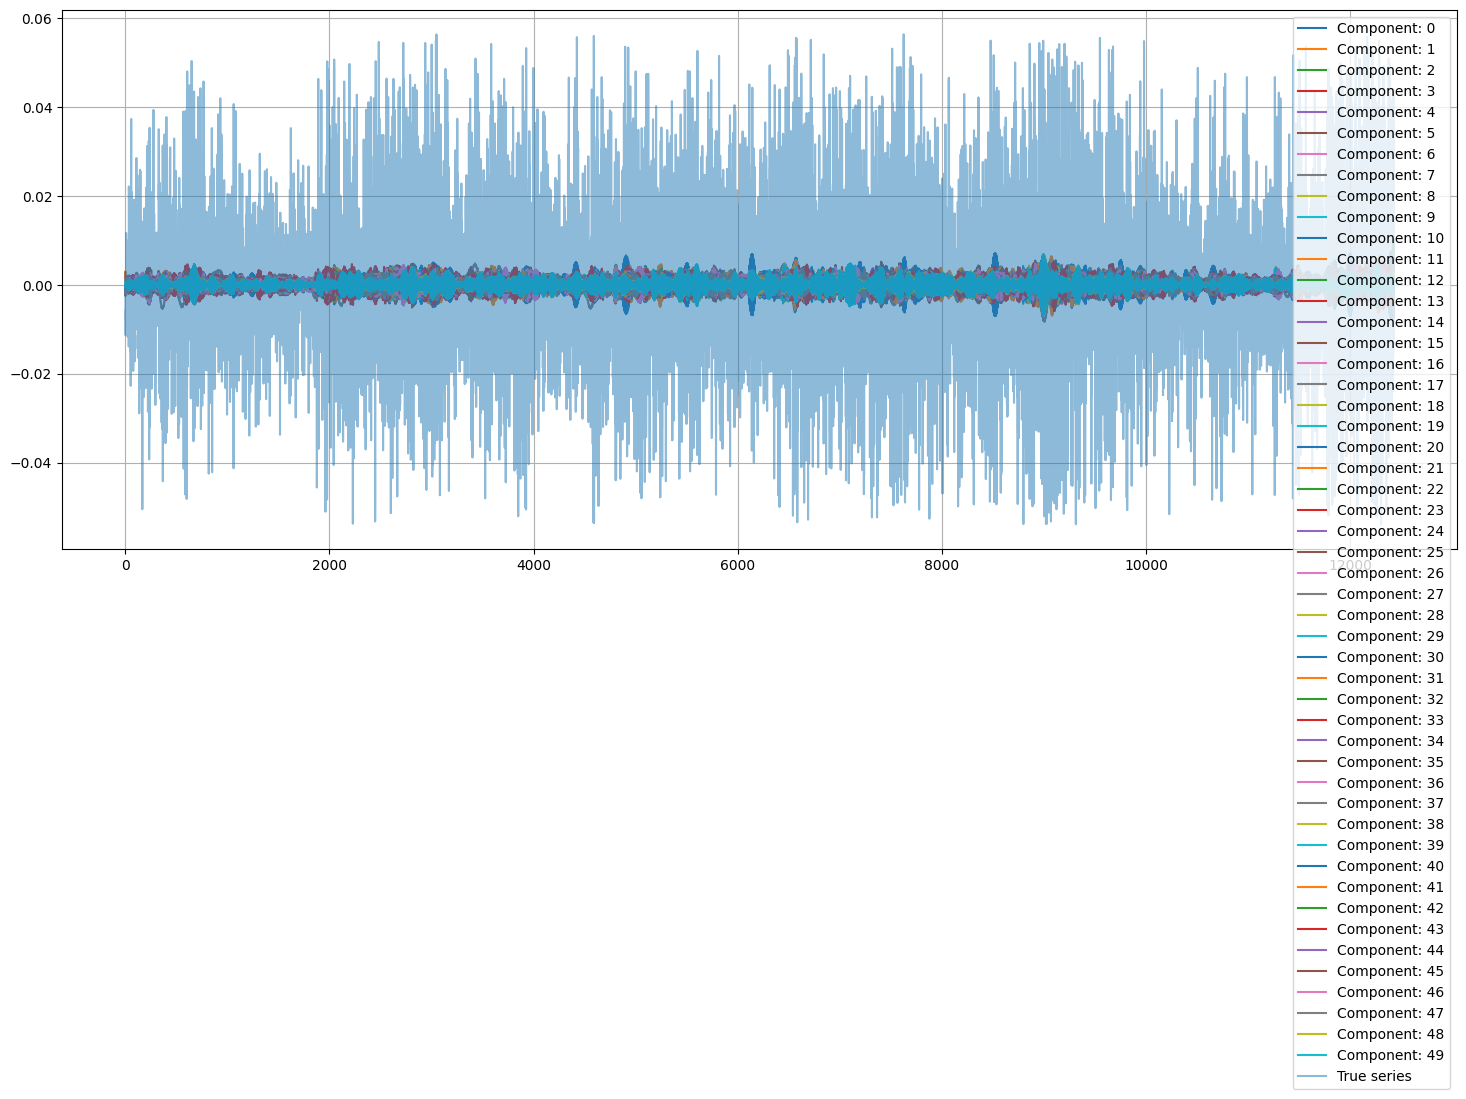

In [20]:
SSA.plot_x_hat(x_hat, new_prc_change_open_prices)

In [21]:
d = len(S[S > 0])
W_corr = SSA.get_W_corr_matrix(x_hat, d, K, L)

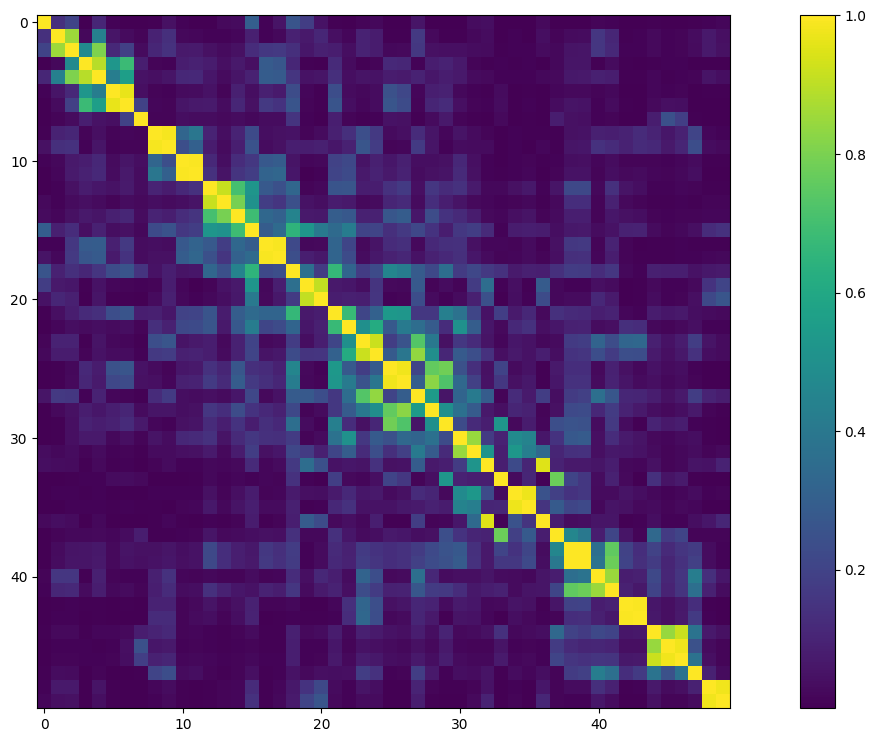

In [22]:
SSA.plot_W_corr(W_corr);

### Алгоритм группировки восстановленых элементов ряда
Основан на статье [Николая Владимировича Абалова](https://www.researchgate.net/publication/297898415_Automatic_Grouping_of_Time_Series_Decomposition_Components_in_Singular_Spectrum_Analysis).

In [23]:
eigen_values = np.power(S, 2)
similarity_eigen_values = np.zeros((eigen_values.shape[0], eigen_values.shape[0]), dtype= np.float64)
similarity_eigen_values.shape

(50, 50)

In [24]:
# Вычисляем матрицу схожести собственных чисел
for i in range(similarity_eigen_values.shape[0]):
    for j in range(i + 1, similarity_eigen_values.shape[1]):
        similarity_eigen_values[i, j] = min(eigen_values[i], eigen_values[j]) / max(eigen_values[i], eigen_values[j])
        # для дальнейшних изысканий нет необходимости делать симметрию, так как матрицы и так симметрична
        # similarity_eigen_values[j, i] = similarity_eigen_values[i, j]

In [25]:
# threshold -> выбор порогов
rho_c = 0.4 # корреляция значима при ее показателе >= 0.3 (для матрицы корреляции восстановленных компонент)
rho_one = 0.98 # близость собственных чисел рассматривается только в случае >= 0.99 (для матрицы схожести собственных чисел)

In [26]:
ind_W_corr = (W_corr >= rho_c).astype(np.int64)
ind_similarity_eigen_values = (similarity_eigen_values >= rho_one).astype(np.int64)
G = ind_W_corr * ind_similarity_eigen_values

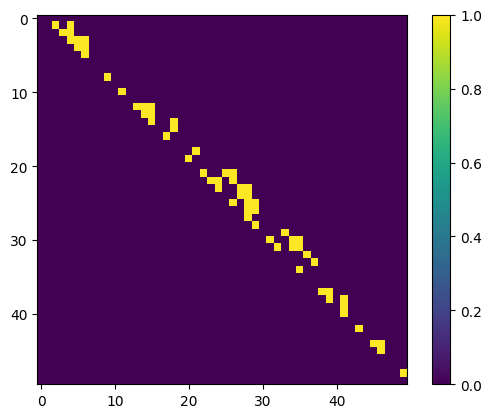

In [27]:
plt.imshow(G.astype(np.float64))
plt.colorbar();

In [28]:
selected_components = G.sum(axis= 0).astype(bool)
selected_components

array([False, False,  True,  True,  True,  True,  True, False, False,
        True, False,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
        True,  True, False, False,  True])

In [29]:
selected_x = x_hat[selected_components, :]
reconstructed_x = selected_x.sum(axis= 0)

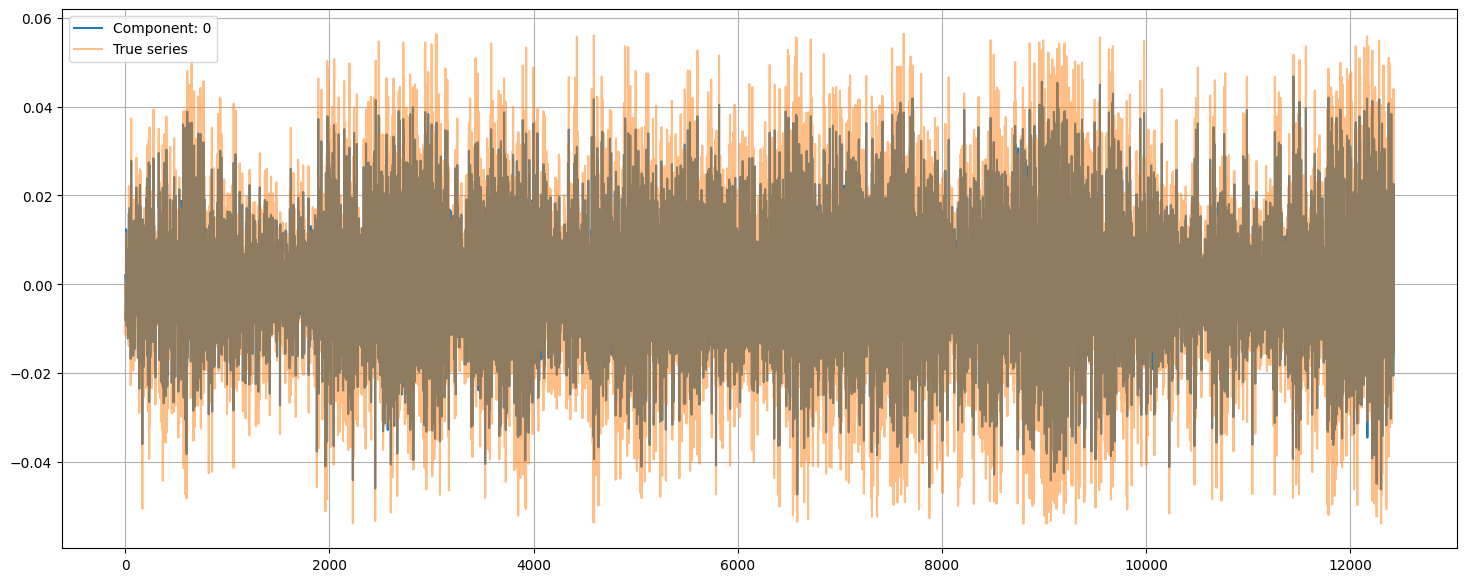

In [30]:
SSA.plot_x_hat(np.array([reconstructed_x]), new_prc_change_open_prices)

In [31]:
residuals = new_prc_change_open_prices - reconstructed_x

### Формирование матрицы траекторий

In [32]:
WINDOW_SIZE = 20 #40
X, y = data_to_X_y(reconstructed_x, window_size= WINDOW_SIZE)
dates_x, dates_y = data_to_X_y(new_dates, window_size= WINDOW_SIZE)

X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)

X.shape, X.dtype, y.shape, y.dtype

(torch.Size([12407, 20, 1]),
 torch.float32,
 torch.Size([12407, 1]),
 torch.float32)

# Разбивка на обучение и тест

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.1,
    shuffle= False
)

dates_train_x, dates_test_x, dates_train_y, dates_test_y = train_test_split(
    dates_x, dates_y,
    test_size= 0.1,
    shuffle= False
)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size= 0.1,
    shuffle= False
)

dates_train_x, dates_val_x, dates_train_y, dates_val_y = train_test_split(
    dates_train_x, dates_train_y,
    test_size= 0.1,
    shuffle= False
)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([10049, 20, 1]),
 torch.Size([1117, 20, 1]),
 torch.Size([1241, 20, 1]),
 torch.Size([10049, 1]),
 torch.Size([1117, 1]),
 torch.Size([1241, 1]))

In [35]:
dates_train_x.shape, dates_train_y.shape, dates_val_x.shape, dates_val_y.shape, dates_test_x.shape, dates_test_y.shape

((10049, 20, 1),
 (10049, 1),
 (1117, 20, 1),
 (1117, 1),
 (1241, 20, 1),
 (1241, 1))

# Скалирование данных

In [36]:
class MinMaxScaler():
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, data):
        self.min = data.min()
        self.max = data.max()

    def transform(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform(self, data):
        return (self.max - self.min) * data + self.min

    def __str__(self):
        return f"Min: {self.min}\nMax: {self.max}"

class StandardScaler():
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        self.mean = data.mean()
        self.std = data.std()

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return self.std * data + self.mean

    def __str__(self):
        return f"Mean: {self.mean}\nStd: {self.std}"

min_max_scl = MinMaxScaler()
std_scl = StandardScaler()

min_max_scl.fit(torch.concat((X_train[0], y_train, y_val), dim= 0))
std_scl.fit(torch.concat((X_train[0], y_train, y_val), dim= 0))

#----------------------------------------------
X_train_min_max = min_max_scl.transform(X_train)
X_val_min_max = min_max_scl.transform(X_val)
X_test_min_max = min_max_scl.transform(X_test)

y_train_min_max = min_max_scl.transform(y_train)
y_val_min_max = min_max_scl.transform(y_val)
y_test_min_max = min_max_scl.transform(y_test)
#----------------------------------------------
X_train_std = std_scl.transform(X_train)
X_val_std = std_scl.transform(X_val)
X_test_std = std_scl.transform(X_test)

y_train_std = std_scl.transform(y_train)
y_val_std = std_scl.transform(y_val)
y_test_std = std_scl.transform(y_test)

In [37]:
print(min_max_scl)

Min: -0.04730147868394852
Max: 0.04559609666466713


In [38]:
print(std_scl)

Mean: 1.3961956028651912e-05
Std: 0.013007777743041515


# Создание датасетов и загрузчиков

In [39]:
class TimeSeriesDataSet(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        return self.X[item], self.y[item]

In [40]:
train_dataset = TimeSeriesDataSet(X_train_min_max, y_train_min_max)
val_dataset = TimeSeriesDataSet(X_val_min_max, y_val_min_max)
test_dataset = TimeSeriesDataSet(X_test_min_max, y_test_min_max)

In [41]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size= 256,
    shuffle= False
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size= 256,
    shuffle= False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size= 256,
    shuffle= False,
)

# Построение модели

In [42]:
class StockPredictor(nn.Module):
    def __init__(
            self,
            input_dim,
            hid_dim,
            out_dim,
            num_layers= 1,
            dropout= 0.0,
            type= "gru"
    ):
        super(StockPredictor, self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.num_layers = num_layers
        self.dropout = dropout
        self.type = type

        assert self.type in ["gru", "lstm", "rnn"], "Unknown block"

        self.recurrent_block = None
        if self.type == "gru":
            self.recurrent_block = nn.GRU(
                self.input_dim, self.hid_dim,
                num_layers= self.num_layers,
                batch_first= True,
                dropout= self.dropout)
        elif self.type == "rnn":
            self.recurrent_block = nn.RNN(
                self.input_dim, self.hid_dim,
                num_layers= self.num_layers,
                batch_first= True,
                dropout= self.dropout)
        else:
            self.recurrent_block = nn.LSTM(
                self.input_dim, self.hid_dim,
                num_layers= self.num_layers,
                batch_first= True,
                dropout= self.dropout)

        self.act = nn.ReLU()
        self.fc = nn.Linear(self.hid_dim, self.out_dim)

    def forward(self, X, device= "cpu"):
        h = torch.zeros((self.num_layers, X.shape[0], self.hid_dim)).to(device)
        c = torch.zeros((self.num_layers, X.shape[0], self.hid_dim)).to(device)

        if self.type in ["gru", "rnn"]:
            ans, h = self.recurrent_block(X, h)
            return self.fc(self.act(ans[:, -1]))
        else:
            ans, (h, c) = self.recurrent_block(X, (h, c))
            return self.fc(self.act(ans[:, -1]))

In [43]:
torch.manual_seed(42)

params = {
    "input_dim": X_train.shape[-1],
    "hid_dim": 10,
    "out_dim": 1,
    "num_layers": 1,
    "type": "lstm",
    "dropout": 0.0
}

model = StockPredictor(**params)

# Функция обучения и тестового вычисления, а также построение графиков

$${sMAPE = \frac{100}{n} \sum_{t = 1}^n \frac{|F_t - A_t|}{|F_t + A_t| / 2}}$$
$${WAPE = \frac{\sum_{t = 1}^{n}|A_t - F_t|}{\sum_{t = 1}^{n}|A_t|}}$$
$${MAPE = \sum_{t = 1}^{n}\frac{|A_t - F_t|}{|A_t|}}$$

In [44]:
from Functions.Metrics import Metrics
from Functions.Train_Eval_Plot import Train_Eval_Plot

In [45]:
metrics_dict = Metrics()

# Обучение модели

In [ ]:
epochs = 1500
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 1e-3)
metric_name = "WAPE"

train_params = {
    "model": model,
    "criterion": criterion,
    "metric": metrics_dict[metric_name],
    "optimizer": optimizer,
    "epochs": epochs,
    "train_data": {
        "train": train_loader,
        "val": val_loader
    },
    "verbose": False,
    "lag": 1,
    "metric_to_max": False,
    "device": "cuda"
}
train_res = Train_Eval_Plot.train(**train_params)

In [ ]:
Train_Eval_Plot.plot_train_res(train_res)

In [ ]:
model.load_state_dict(train_res["best model"])

In [ ]:
eval_res = Train_Eval_Plot.eval(model, test_loader, metrics_dict[metric_name], criterion, device= "cpu")

In [ ]:
Train_Eval_Plot.plot_eval_res(eval_res, y_test_min_max, min_max_scl, dates_test_y, start= -200, end= None)